#### import librarires and required modules

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import tensorboard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, UpSampling2D,Dropout
from keras.utils import to_categorical, plot_model

#### use gpu as our training device

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### load data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### pre-process data to fit the ResNet50 model

In [6]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = np.repeat(X_train, 3, axis=-1)
X_train = X_train.astype('float32') / 255
X_train = tf.image.resize(X_train, [32,32])
X_train.shape

TensorShape([60000, 32, 32, 3])

In [7]:
X_test = np.expand_dims(X_test, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
X_test = X_test.astype('float32') / 255
X_test = tf.image.resize(X_test, [32,32])
X_test.shape

TensorShape([10000, 32, 32, 3])

In [8]:
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=10)

In [9]:
print((y_train.shape, y_test.shape))

((60000, 10), (10000, 10))


#### define model architecture on top of ResNet50

In [10]:
input = tf.keras.Input(shape=(32,32,3))
resnet50_finetuned = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False,
                                             input_tensor = input)
# global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(resnet50_finetuned.output)

# classification layer w.r.t 10 classes
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

# bind all
model = tf.keras.Model(resnet50_finetuned.input, output)

94765736/94765736 [==============================] - 5s 0us/step


#### check summary of the model architecture

In [ ]:
model.summary()

In [12]:
X, y = np.array(X_train), np.array(y_train)
validation_split = 0.2
X_train_model, X_val_model, y_train_model, y_val_model = train_test_split(X, y, test_size=validation_split, random_state=42)

X_train = tf.convert_to_tensor(X_train_model)
X_val = tf.convert_to_tensor(X_val_model)

y_train = tf.convert_to_tensor(y_train_model)
y_val = tf.convert_to_tensor(y_val_model)

#### train the model

In [13]:
model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# # fit
# func_model.fit(x_train, y_train, batch_size=128, epochs=5, verbose = 2)

history = model.fit(X_train_model,
                        y_train_model,
                        epochs=8,
                        batch_size=256,
                        validation_data=(X_val_model, y_val_model))

Epoch 1/8
188/188 [==============================] - 74s 116ms/step - loss: 0.1375 - categorical_accuracy: 0.9634 - val_loss: 8.0244 - val_categorical_accuracy: 0.1102
Epoch 2/8
188/188 [==============================] - 17s 92ms/step - loss: 0.0370 - categorical_accuracy: 0.9896 - val_loss: 6.8812 - val_categorical_accuracy: 0.1102
Epoch 3/8
188/188 [==============================] - 18s 94ms/step - loss: 0.0243 - categorical_accuracy: 0.9929 - val_loss: 1.8808 - val_categorical_accuracy: 0.3122
Epoch 4/8
188/188 [==============================] - 18s 94ms/step - loss: 0.0248 - categorical_accuracy: 0.9927 - val_loss: 0.1498 - val_categorical_accuracy: 0.9576
Epoch 5/8
188/188 [==============================] - 18s 95ms/step - loss: 0.0187 - categorical_accuracy: 0.9946 - val_loss: 0.1367 - val_categorical_accuracy: 0.9607
Epoch 6/8
188/188 [==============================] - 18s 95ms/step - loss: 0.0171 - categorical_accuracy: 0.9953 - val_loss: 0.0794 - val_categorical_accuracy: 0.98

In [ ]:
plot_model(model, to_file='mnist-ResNet50-finetuned.png', show_shapes=True)

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

#### plot metrics

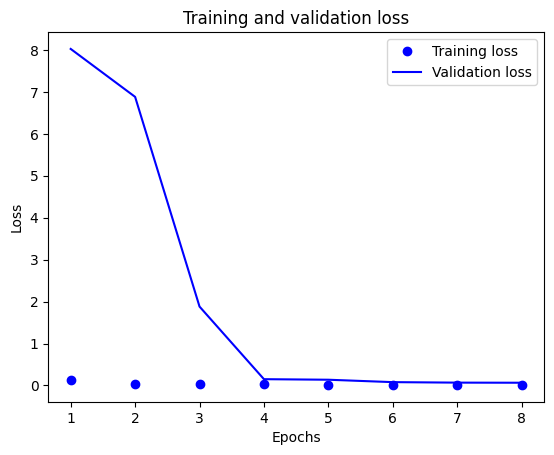

In [16]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

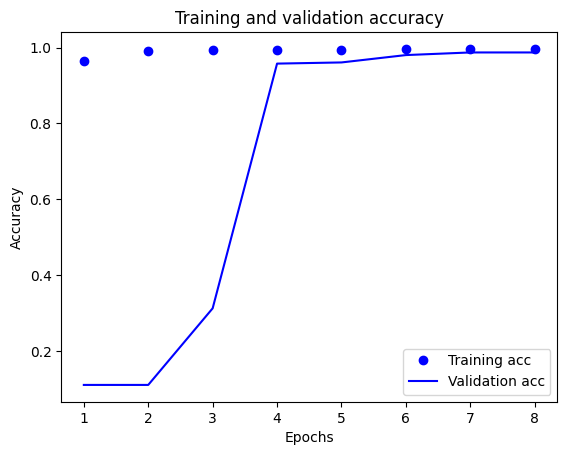

In [17]:
plt.clf()
acc = history_dict["categorical_accuracy"]
val_acc = history_dict["val_categorical_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### test accuracy

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"test accuracy: {test_acc} \ntest loss: {test_loss}")

313/313 [==============================] - 4s 11ms/step - loss: 0.0515 - categorical_accuracy: 0.9883
test accuracy: 0.9883000254631042 
test loss: 0.05154626443982124
